# Variational AutoEncoders (VAE)

SOurce: [Variational AutoEncoders (VAE) with PyTorch](https://avandekleut.github.io/vae/)

Supposed we have a dataset of images. Each image has hundreds of pixels, so each "data point" has hundreds of dimensions. The **manifold hypothesis** states that real-world high-dimensional data can be sufficiently described using only a few dimensions.

Examples of dimensionality reduction techniques include **principal component analysis** (PCA) and **t-SNE**.

## Autoencoder

Autoencoders are neural networks used to perform dimensionality reduction composed of two networks, an **encoder** $e$ and a **decoder** $d$.

The **encoder** learns a non-linear transformation $e: X \to Z$ that projects data from the high-dimensional input space $X$ to a lower-dimensional **latent space** $Z$. We call $z = e(x)$ a **latent vector**. 

A **latent vector** is a low-dimensional **representation** of a data point that contains information about $x$.

A **decoder** learns a non-linear transformation $d: Z \to X$ that projects the latent vectors back into the original high-dimensional input space $X$. This transformation should take the latent vector and reconstruct the original input data $\hat{x} = d(z)$.

An **autoencoder** is the composition of the encoder and the decoder

$$
f(x) = d(e(x))
$$

The autoencoder is trained to minimize the difference between the input $x$ and the reconstruction $\hat{x}$ using a kind of **reconstruction loss** and simultaneosly optimizes the encoder and the decoder.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Autoencoder Model

![AE](images/autoencoder.png)

**source**: [avandekleut.github.io/vae](https://avandekleut.github.io/vae/)

In [2]:
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, z_dim)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)


class Decoder(nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(z_dim, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))
    

class Autoencoder(nn.Module):
    def __init__(self, z_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

### Training of MNIST Data

In [3]:
z_dim = 2
lr = 0.001
epochs = 20

autoencoder = Autoencoder(z_dim).to(device)

trainset = datasets.MNIST('.', transform=transforms.ToTensor(), download=True)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, drop_last=True)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

epoch_losses = []

for epoch in range(epochs):
    epoch_loss = 0.0
    for x, y in trainloader:
        x = x.to(device)
        optimizer.zero_grad()
        x_hat = autoencoder(x)
        loss = loss_fn(x, x_hat)
        epoch_loss = epoch_loss + loss.data.cpu()
        loss.backward()
        optimizer.step()
    epoch_loss = epoch_loss / len(trainloader)
    print(f'Epoch: {epoch}, Loss: {epoch_loss}')
    epoch_losses.append(epoch_loss)

Epoch: 0, Loss: 0.056048788130283356
Epoch: 1, Loss: 0.04773325100541115
Epoch: 2, Loss: 0.04611298441886902
Epoch: 3, Loss: 0.04517224058508873
Epoch: 4, Loss: 0.04433011636137962
Epoch: 5, Loss: 0.04361444711685181
Epoch: 6, Loss: 0.043052274733781815
Epoch: 7, Loss: 0.04259713739156723
Epoch: 8, Loss: 0.042194169014692307
Epoch: 9, Loss: 0.041853033006191254
Epoch: 10, Loss: 0.041578296571969986
Epoch: 11, Loss: 0.04129970818758011
Epoch: 12, Loss: 0.041061826050281525
Epoch: 13, Loss: 0.04082268849015236
Epoch: 14, Loss: 0.040621813386678696
Epoch: 15, Loss: 0.040443453937768936
Epoch: 16, Loss: 0.040248118340969086
Epoch: 17, Loss: 0.04006475210189819
Epoch: 18, Loss: 0.03995027393102646
Epoch: 19, Loss: 0.039784952998161316


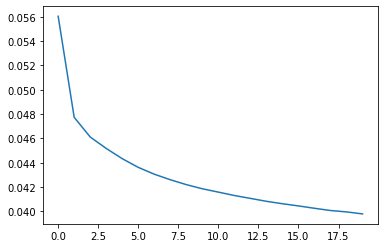

In [4]:
plt.plot(epoch_losses);

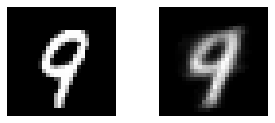

In [5]:
testset = datasets.MNIST(root='.', transform=transforms.ToTensor(), download=True, train=False)
testloader = DataLoader(testset, batch_size=128, shuffle=True, drop_last=True)

batch0 = next(iter(testloader))
img = batch0[0][0]
img_hat = autoencoder(img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2))
ax1.axis('off')
ax1.imshow(img.squeeze(0), cmap='gray')
ax2.axis('off')
ax2.imshow(img_hat.detach().squeeze(0).squeeze(0), cmap='gray');

### Latent Space

If we choose a **2-dimensional** latent space, then we can make a scatterplot of the output **latent vectors**.

In [10]:
len(trainloader)

468

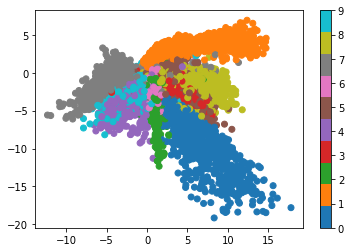

In [17]:
for x, y in testloader:
    z = autoencoder.encoder(x.to(device))
    z = z.cpu().detach().numpy()
    plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
plt.colorbar();